In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 236 kB 18.3 MB/s 
     |████████████████████████████████| 140 kB 72.5 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import pickle
from sklearn.cluster import DBSCAN
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials


In [ ]:
class Preprocessing:
  def __init__(self,train_link):
    self.__df = pd.read_csv(train_link)
    self.__pve_list = []
    self.__pca = 0
    self.__df_processed = 0
    self.__number_of_components = 0
    self.__scaler = 0


  def one_hot_encoding(self,dataframe):
    keys = dataframe["key"].to_numpy()
    keys = np.array(['A', 'A#', 'B','C','C#','D', 'D#','E', 'F','F#' ,'G',  'G#'])
    modes = dataframe["mode"].to_numpy()
    modes = np.array(["Major", "Minor"])
    
    index_key = []
    for i in keys:
      index_key.append(np.where(np.array(dataframe["key"])==i))
    
    index_mode = []
    for i in modes:
      index_mode.append(np.where(np.array(dataframe["mode"])==i))


    lis2 = np.zeros((len(keys),len(dataframe)))
    for j in range(0,len(index_key)):
      for i in index_key[j]:
        lis2[j][i]=1
    #df_copy2=df.copy().reset_index()

    dataframe_new2= pd.DataFrame(lis2).T
    dataframe_new2.columns= keys
    dataframe= pd.concat([dataframe,dataframe_new2],axis=1)
    dataframe = dataframe.drop(columns = "key")
    
    lis3 = np.zeros((2,len(dataframe)))
    for j in range(0,len(index_mode)):
      for i in index_mode[j]:
        lis3[j][i]=1
    #df_copy3=df.copy().reset_index()

    dataframe_new3= pd.DataFrame(lis3).T
    dataframe_new3.columns= modes
    dataframe= pd.concat([dataframe,dataframe_new3],axis=1)
    dataframe = dataframe.drop(columns = ["mode"])
    return dataframe
  def preprocess_train_shape(self):
    df = self.__df
    df = df.drop(["artist_name","track_name","track_id","genre"],axis=1)
    df = self.one_hot_encoding(df)
    List1= [0,1,3,4,5]
    List2 = np.unique(df["time_signature"].to_numpy())
    Dic = dict(zip(List2, List1))
    df=df.replace({"time_signature": Dic})
    self.__scaler = MaxAbsScaler()
    df[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.fit_transform(df[["popularity","duration_ms","tempo","loudness","time_signature"]])
    self.__df = df
    self.__df_processed = df
    
  def get_processed_df(self):
    return self.__df_processed

  def get_PCA_plot(self):
    df = self.__df_processed
    arr = df.to_numpy()
    self.__number_of_components = [x for x in range(1,26)]
    

    for component in self.__number_of_components:
      pca = PCA(n_components=component)
      pca.fit(arr)
      self.__pve_list.append(np.sum(pca.explained_variance_ratio_))

    return self.__number_of_components, self.__pve_list



  def get_PVE(self):
    for i in range(len(self.__pve_list)):
      print(f"Number of components:{self.__number_of_components[i]} -> PVE:{self.__pve_list[i]}")
    
  def preprocess_train(self):
    self.preprocess_train_shape()   
    #Apply PCA with 0.9 PVE
    arr = self.__df.to_numpy()
    self.__pca = PCA(0.9)
    self.__pca.fit(arr)
    transformed_arr = self.__pca.transform(arr)
    transformed_df = pd.DataFrame(data=transformed_arr,columns=[f"principal_componenet {x+1}" for x in range(transformed_arr.shape[1])])
    return transformed_df
  
  def preprocess_test(self,test):
    #self.preprocess_train()
    test = pd.read_csv(test)
    test = test.drop(columns=["Unnamed: 0"],axis=1)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    transformed_test = self.__pca.transform(test)
    test = pd.DataFrame(data=transformed_test,columns=[f"principal_componenet {x+1}" for x in range(transformed_test.shape[1])])
    test = test.mean()
    test = test.to_numpy()
    test = pd.DataFrame(data=test.reshape(1,15),columns=[f"principal_componenet {x+1}" for x in range(test.shape[0])])
    return test
  
  def call_playlist(self,link):
    #Authentication - without user
    client_credentials_manager = SpotifyClientCredentials(client_id="", client_secret="")
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

    playlist_link = link
    playlist_URI = playlist_link.split("/")[-1].split("?")[0]
    track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]
    keys = ["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms"]
    dictionary = {}
    for i in sp.audio_features(track_uris):
      for key in i:
        if key not in dictionary:
          dictionary[key] = []
        dictionary[key].append(i[key])
    df = pd.DataFrame.from_dict(dictionary)
    popularity=[]
    for track in sp.playlist_tracks(playlist_URI)["items"]:
        popularity.append(track["track"]["popularity"])

    df_pop = pd.DataFrame(popularity)
    df_pop.columns=["popularity"]
    df=pd.concat([df_pop,df],axis=1)
    df = df.drop(["type","id","uri","track_href","analysis_url"],axis = 1)  

    test = df.to_csv("test.csv") 
    return df

  def preprocess_test_link(self,link):
    test = self.call_playlist(link)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    transformed_test = self.__pca.transform(test)
    test = pd.DataFrame(data=transformed_test,columns=[f"principal_componenet {x+1}" for x in range(transformed_test.shape[1])])
    test = test.mean()
    test = test.to_numpy()
    test = pd.DataFrame(data=test.reshape(1,15),columns=[f"principal_componenet {x+1}" for x in range(test.shape[0])])
    return test

  def preprocess_test_AE(self,test):
    #self.preprocess_train()
    test = pd.read_csv(test)
    test = test.drop(columns=["Unnamed: 0"],axis=1)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    return test

  def preprocess_test_link_AE(self,link):
    test = self.call_playlist(link)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    return test

In [ ]:
df_original = pd.read_csv("/content/drive/MyDrive/CS464/Kod/SpotifyFeatures.csv")

In [ ]:
df_without_pca=Preprocessing("/content/drive/MyDrive/CS464/Kod/SpotifyFeatures.csv")

In [ ]:
df_new = df_without_pca.preprocess_train_shape()

In [ ]:
df_new=df = df_without_pca.get_processed_df()

In [ ]:
df_new.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,C#,D,D#,E,F,F#,G,G#,Major,Minor
0,0.00,0.611,0.389,0.017896,0.910,0.000,0.3460,-0.034848,0.0525,0.687390,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.01,0.246,0.590,0.024739,0.737,0.000,0.1510,-0.105973,0.0868,0.716348,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.03,0.952,0.663,0.030663,0.131,0.000,0.1030,-0.264579,0.0362,0.409579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.00,0.703,0.240,0.027450,0.326,0.000,0.0985,-0.232152,0.0395,0.707105,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.04,0.950,0.331,0.014880,0.225,0.123,0.2020,-0.403187,0.0456,0.578733,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df_original.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [ ]:
dataframe = Preprocessing("/content/drive/MyDrive/CS464/Kod/SpotifyFeatures.csv")

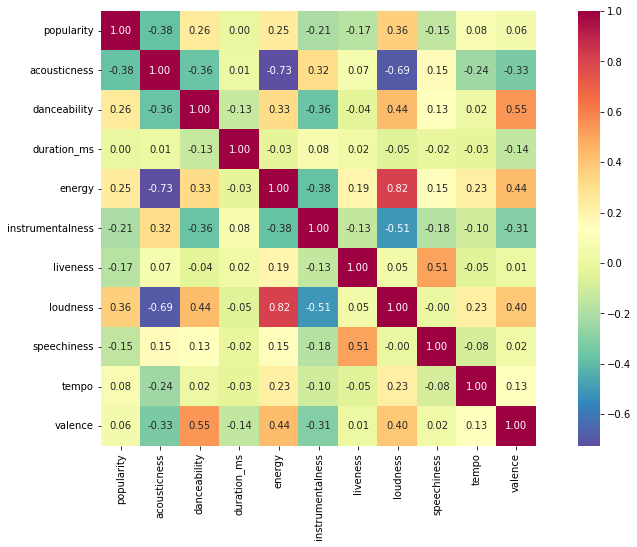

In [ ]:
plt.figure(figsize=(15,8))
corrmat = df_original.drop(columns=["artist_name","track_name","track_id","genre"]).corr()
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={"size":10},cmap ="Spectral_r")
plt.show()

In [ ]:
df = dataframe.preprocess_train()

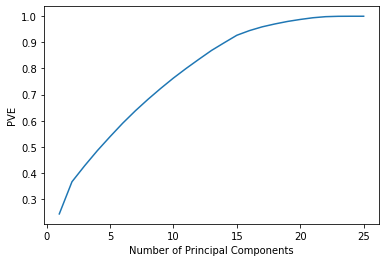

In [ ]:
b =dataframe.get_PCA_plot()
plt.plot(b[0], b[1])
plt.xlabel("Number of Principal Components")
plt.ylabel("PVE")
plt.show()

In [ ]:
dataframe.get_PVE()

Number of components:1 -> PVE:0.24326171448086417
Number of components:2 -> PVE:0.36642277375950494
Number of components:3 -> PVE:0.427687922504493
Number of components:4 -> PVE:0.4854302851773586
Number of components:5 -> PVE:0.538908149162076
Number of components:6 -> PVE:0.5905325992705048
Number of components:7 -> PVE:0.6381070666438281
Number of components:8 -> PVE:0.6822445111565804
Number of components:9 -> PVE:0.7238491120065759
Number of components:10 -> PVE:0.7634003162696886
Number of components:11 -> PVE:0.8001213740232964
Number of components:12 -> PVE:0.8349905522255143
Number of components:13 -> PVE:0.8689735733525884
Number of components:14 -> PVE:0.8984491065831991
Number of components:15 -> PVE:0.9271934253856331
Number of components:16 -> PVE:0.9451263591921625
Number of components:17 -> PVE:0.9594644380247296
Number of components:18 -> PVE:0.9704866018618878
Number of components:19 -> PVE:0.9800929895571009
Number of components:20 -> PVE:0.987724569798119
Number of 

In [ ]:
new_t = dataframe.preprocess_test_link("https://open.spotify.com/playlist/37i9dQZF1DX5cc7vmfioLh?si=98e16ff9c12748ef")

<ipython-input-5-91080807fefa>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_key.append(np.where(np.array(dataframe["key"])==i))
<ipython-input-5-91080807fefa>:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_mode.append(np.where(np.array(dataframe["mode"])==i))
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [ ]:
new_t_nopca = dataframe.preprocess_test_link_AE("https://open.spotify.com/playlist/37i9dQZF1DX5cc7vmfioLh?si=98e16ff9c12748ef")

<ipython-input-5-91080807fefa>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_key.append(np.where(np.array(dataframe["key"])==i))
<ipython-input-5-91080807fefa>:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_mode.append(np.where(np.array(dataframe["mode"])==i))


In [ ]:
test_trial= dataframe.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_test_pl_1.csv")

<ipython-input-5-91080807fefa>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_key.append(np.where(np.array(dataframe["key"])==i))
<ipython-input-5-91080807fefa>:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_mode.append(np.where(np.array(dataframe["mode"])==i))


In [ ]:
test_1 = dataframe.preprocess_test("/content/drive/MyDrive/CS464/Kod/test_test_pl_1.csv")
test_2 = dataframe.preprocess_test("/content/drive/MyDrive/CS464/Kod/test_test_pl_2.csv")
test_3 = dataframe.preprocess_test("/content/drive/MyDrive/CS464/Kod/test_pl3.csv")
test_4 = dataframe.preprocess_test("/content/drive/MyDrive/CS464/Kod/test_sanat_muzigi.csv")
test_5 = dataframe.preprocess_test("/content/drive/MyDrive/CS464/Kod/test_ucuncu_yeniler.csv")
test_6 = dataframe.preprocess_test("/content/drive/MyDrive/CS464/Kod/test_metal.csv")
test_7 = dataframe.preprocess_test("/content/drive/MyDrive/CS464/Kod/test_dylan.csv")
test_7

<ipython-input-5-91080807fefa>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_key.append(np.where(np.array(dataframe["key"])==i))
<ipython-input-5-91080807fefa>:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_mode.append(np.where(np.array(dataframe["mode"])==i))
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
<ipython-input-5-91080807fefa>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_key.append(np.where(np.array(dataframe["key"])==i))
<ipython-input-5-91080807fefa>:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_mode.append(np

,principal_componenet 1,principal_componenet 2,principal_componenet 3,principal_componenet 4,principal_componenet 5,principal_componenet 6,principal_componenet 7,principal_componenet 8,principal_componenet 9,principal_componenet 10,principal_componenet 11,principal_componenet 12,principal_componenet 13,principal_componenet 14,principal_componenet 15
0,0.205906,0.414435,-0.015871,-0.009437,0.026204,-0.004298,-0.001039,0.025625,0.02569,0.027939,0.074279,-0.0249,0.009636,0.346997,0.191085


In [ ]:
test_6

,principal_componenet 1,principal_componenet 2,principal_componenet 3,principal_componenet 4,principal_componenet 5,principal_componenet 6,principal_componenet 7,principal_componenet 8,principal_componenet 9,principal_componenet 10,principal_componenet 11,principal_componenet 12,principal_componenet 13,principal_componenet 14,principal_componenet 15
0,0.215546,-0.060481,-0.004439,-0.013929,0.058618,0.007065,0.162407,-0.279965,-0.122524,0.018138,0.00445,-0.062837,0.081533,0.356759,-0.054239


#**k-Means**

In [ ]:
!pip install kneed
from kneed.knee_locator import KneeLocator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
number_of_clusters = [n for n in range(50,1050,50)]
inertias = []
silhouttes = []

for n in number_of_clusters:
  model = KMeans(n_clusters=n).fit(transformed_arr)
  labels = model.labels_
  inertias.append(model.inertia_)
  score = silhouette_score(transformed_arr,labels,metric="euclidean")
  print(f"Silhouette score for {n} clusters is {score}")
  silhouttes.append(score)

with open('/content/drive/MyDrive/CS464/Kod/kmeans_score.pickle', 'wb') as f:
    pickle.dump(silhouttes, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/CS464/Kod/kmeans_inertia.pickle', 'wb') as f:
    pickle.dump(inertias, f, protocol=pickle.HIGHEST_PROTOCOL)

Silhouette score for 50 clusters is 0.42008039136057435
Silhouette score for 100 clusters is 0.3538373581458919
Silhouette score for 150 clusters is 0.3331172298310007
Silhouette score for 200 clusters is 0.31293854123678894
Silhouette score for 250 clusters is 0.29774047163308676
Silhouette score for 300 clusters is 0.28577268141206097
Silhouette score for 350 clusters is 0.2750110579203507
Silhouette score for 400 clusters is 0.26859800356111235
Silhouette score for 450 clusters is 0.260480115094621
Silhouette score for 500 clusters is 0.25369641381682795
Silhouette score for 550 clusters is 0.25089228872283104
Silhouette score for 600 clusters is 0.24802575698262386
Silhouette score for 650 clusters is 0.24513512971202156
Silhouette score for 700 clusters is 0.24244129546620866
Silhouette score for 750 clusters is 0.2399839222887252
Silhouette score for 800 clusters is 0.23798364275346717
Silhouette score for 850 clusters is 0.23752574029947307
Silhouette score for 900 clusters is 0

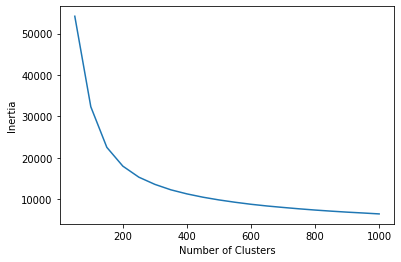

In [ ]:
plt.plot(number_of_clusters, inertias)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [ ]:
with open('/content/drive/MyDrive/CS464/Kod/kmeans_inertia.pickle', 'rb') as f:
    inertias=pickle.load(f)

knee_locator = KneeLocator(range(50,1050,50),inertias,curve="convex", direction="decreasing")
print(f"Elbow for the inertia graph is {knee_locator.elbow}")

Elbow for the inertia graph is 250


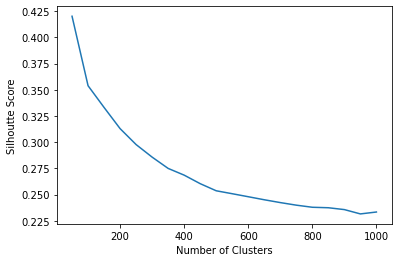

In [ ]:
plt.plot(number_of_clusters, silhouttes)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")
plt.show()

In [ ]:
model = KMeans(n_clusters=1000).fit(df.to_numpy())

In [ ]:
print(np.unique(model.labels_,return_counts=True))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

In [ ]:
print(model.predict(test_1.to_numpy()))
print(model.predict(test_2.to_numpy()))
print(model.predict(test_3.to_numpy()))
print(model.predict(test_4.to_numpy()))
print(model.predict(test_5.to_numpy()))
print(model.predict(test_6.to_numpy()))
print(model.predict(test_7.to_numpy()))

[477]
[477]
[947]
[926]
[477]
[141]
[926]


In [ ]:
df_with_clusters = df_original.copy()
df_with_clusters["cluster"] = model.labels_

In [ ]:
df_with_clusters[df_with_clusters["artist_name"] == "Metallica"][["artist_name","track_name","cluster"]]

,artist_name,track_name,cluster
153065,Metallica,Moth Into Flame,695
153069,Metallica,Holier Than Thou,491
153210,Metallica,The Four Horsemen (Remastered),772
153245,Metallica,The Thing That Should Not Be (Remastered),759
153696,Metallica,Fight Fire With Fire (Remastered),907
153797,Metallica,Until It Sleeps,305
153836,Metallica,"Atlas, Rise!",888
153842,Metallica,Of Wolf And Man,768
153862,Metallica,Orion (Remastered),96
153963,Metallica,The Memory Remains,462


In [ ]:
def recommend_song(playlist,model,df_with_clusters):
  playlist_cluster = model.predict(playlist)[0]
  df_filtered = df_with_clusters[df_with_clusters["cluster"] == playlist_cluster]
  song_rec = df_filtered.sample(10)
  return song_rec[["artist_name","track_name"]]

In [ ]:
recommend_song(test_1.to_numpy(),model,df_with_clusters)

,artist_name,track_name
142391,Brent Faiyaz,Burn One (Interlude)
116183,Mac Miller,We (feat. CeeLo Green)
139602,Lenny Tavárez,Caviar (Remix) [feat. Kevin Roldan & Darell]
232126,Surfaces,Loving (Acoustic)
232112,Dwele,I'm Cheatin'
147269,Benny Sings,Everything I Know
109123,blackbear,Weak When Ur Around
156241,Belle & Sebastian,"Piazza, New York Catcher"
94996,Mac Ayres,Under
194825,Martin & les fées,La petite flamme (par Lorie Pester)


In [ ]:
ind = np.argwhere(np.array(df_original.track_name)=="La petite flamme (par Lorie Pester)")
labels = df.iloc[ind[0][0]].T.index
values = df.iloc[ind[0][0]].T.values

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
print('Mean squared error of recomended song and test_1 playlist:', mean_squared_error(test_1.T.values,values))
print('R2 score of recomended song and test_1 playlist:', r2_score(values,test_1.T.values))

Mean squared error of recomended song and test_1 playlist: 0.037304920639516646
R2 score of recomended song and test_1 playlist: 0.5242376057642408


In [ ]:
recommend_song(test_3.to_numpy(),model,df_with_clusters)

,artist_name,track_name
47090,Phish,Roses Are Free
75558,Juice Music,Monsters Go Rrr
133727,Toots & The Maytals,Bam Bam
73284,The Countdown Kids,The Twelve Days Of Christmas
64916,The Lovin' Spoonful,Butchie's Tune
184344,Cliff Edwards,Mickey Mouse Club Book Song
55190,Noname,Self
193321,Frankie Valli & The Four Seasons,Walk Like A Man
146164,The Main Ingredient,Everybody Plays the Fool
71797,Toddler Tunes,Humpty Dumpty


In [ ]:
recommend_song(test_4.to_numpy(),model,df_with_clusters)

,artist_name,track_name
221458,Mulatu Astatke,Girl From Addis Ababa
217604,Boubacar Traoré,Hona
11449,Santi,Sparky
147123,leaf beach,Travls
53568,"Bobby ""Blue"" Bland",I Ain't Gonna Be The First To Cry
38849,Bonobo,Between The Lines - Instrumental
193101,DROELOE,Only Be Me - Duskus Remix
148699,leaf beach,flowin'
177228,Mujo,El Manaba
177885,Artie Shaw,The Chant


In [ ]:
recommend_song(test_6.to_numpy(),model,df_with_clusters)

,artist_name,track_name
138110,Emicida,Baiana
55311,Chorus,Taaliyan Bajao
196299,Chorus,Maandhalirina
88047,Young Thug,Stoner
159914,Lary Over,Pineapple Express
89171,Smino,Glass Flows
118049,Russ,Prosper
165494,Nikki Mackliff,Búscame
187531,The Skints,Rubadub (Done Know)
159184,Lirico En La Casa,Subelo a Toa


# **DBSCAN**

If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=30) #15*2=30
nbrs = neigh.fit(df)
distances, indices = nbrs.kneighbors(df)

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]


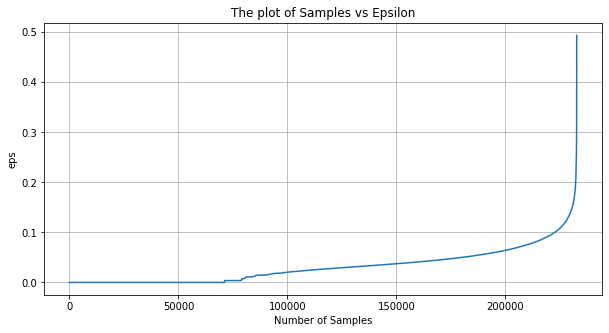

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title("The plot of Samples vs Epsilon")
plt.xlabel("Number of Samples")
plt.ylabel("eps")

plt.grid()

In [ ]:
#try with eps values ranging from 0.1 to 0.2
eps_values = np.arange(0.1,0.21,0.01)
silhouttes = []

for eps in eps_values:  
  clustering = DBSCAN(eps=eps, min_samples=30).fit(df)
  labels = clustering.labels_
  dbscan_score = silhouette_score(df, labels)
  print(f"Silhouette score for {eps} eps is {dbscan_score}")
  silhouttes.append(dbscan_score)

Silhouette score for 0.1 eps is 0.05431820445899462
Silhouette score for 0.11 eps is 0.17193790914090096
Silhouette score for 0.12 eps is 0.20487789691257177
Silhouette score for 0.13 eps is 0.219836609326616
Silhouette score for 0.13999999999999999 eps is 0.19104142954853057
Silhouette score for 0.14999999999999997 eps is 0.21653108302542712
Silhouette score for 0.15999999999999998 eps is 0.2666418313199787
Silhouette score for 0.16999999999999998 eps is 0.27397195685137454
Silhouette score for 0.17999999999999997 eps is 0.2880386743341933
Silhouette score for 0.18999999999999995 eps is 0.3016380179106426
Silhouette score for 0.19999999999999996 eps is 0.30675335861591246


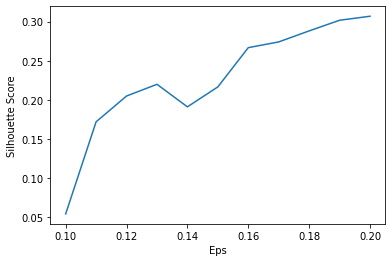

In [ ]:
plt.plot(np.arange(0.1,0.21,0.01),silhouttes)
plt.xlabel("Eps")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
#parameter tuning for eps varying from 0.2 to 0.49

score_list=[]
whole_turns = []
for eps in np.arange(0.20,0.52,0.02):
  clustering = DBSCAN(eps=eps, min_samples=30).fit(df)
  labels = clustering.labels_
  score = silhouette_score(df, labels)
  score_list.append(score)
  whole_turns.append([eps,30]) 
  print(f"Silhouette score for {eps} eps is {score}")
max_score_index = score_list.index(max(score_list))
choice = whole_turns[max_score_index]
print('Best parameteres:','epsilon:',choice[0],'min_samples:',choice[1],'Silhoutte Score:',score_list[max_score_index])         

Silhouette score for 0.2 eps is 0.3067533586159059
Silhouette score for 0.22 eps is 0.3380618382369138
Silhouette score for 0.24 eps is 0.3481651081958027
Silhouette score for 0.26 eps is 0.35672993070627845
Silhouette score for 0.27999999999999997 eps is 0.32954650157292714
Silhouette score for 0.29999999999999993 eps is 0.3660360423510578
Silhouette score for 0.31999999999999995 eps is 0.38594506828542285
Silhouette score for 0.33999999999999997 eps is 0.3863522121801671
Silhouette score for 0.35999999999999993 eps is 0.39562655098241617
Silhouette score for 0.3799999999999999 eps is 0.3957499032840953
Silhouette score for 0.3999999999999999 eps is 0.3957333725446692
Silhouette score for 0.41999999999999993 eps is 0.39349135956495257
Silhouette score for 0.4399999999999999 eps is 0.39223666732652873
Silhouette score for 0.4599999999999999 eps is 0.38841602054430563
Silhouette score for 0.47999999999999987 eps is 0.39042382575102386
Silhouette score for 0.49999999999999983 eps is 0.39

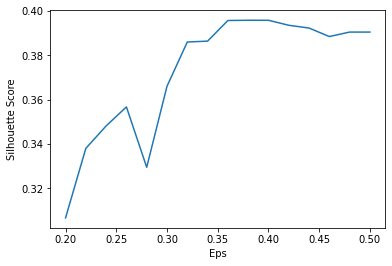

In [ ]:
plt.plot(np.arange(0.20,0.52,0.02),score_list)
plt.xlabel("Eps")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
tuned_dbscan_08 = DBSCAN(eps=0.8, min_samples=30).fit(df)

In [ ]:
dbscan_nopca = DBSCAN(eps=0.8, min_samples=42).fit(df_new)

In [ ]:
silhouette_score(df_new, dbscan_nopca.labels_)

0.443347232968833

In [ ]:
np.unique(dbscan_nopca.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([16246,  7125,  5639, 11758,  8097, 21944, 20029,  8724,  5108,
        11329, 18466,  8666,  7442,  6361,  8795,  9520,  8084, 13876,
         8141,  8521,  5611,  6955,  3830,  2458]))

In [ ]:
def dbscan_predict(model, X):

    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

In [ ]:
print(dbscan_predict(dbscan_nopca,new_t_nopca.to_numpy()))


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1]


In [ ]:
print(dbscan_predict(tuned_dbscan_08,test_1.to_numpy()))
print(dbscan_predict(tuned_dbscan_08,test_2.to_numpy()))
print(dbscan_predict(tuned_dbscan_08,test_3.to_numpy()))
print(dbscan_predict(tuned_dbscan_08,test_4.to_numpy()))
print(dbscan_predict(tuned_dbscan_08,test_5.to_numpy()))
print(dbscan_predict(tuned_dbscan_08,test_6.to_numpy()))
print(dbscan_predict(tuned_dbscan_08,test_7.to_numpy()))

[23]
[23]
[8]
[23]
[23]
[23]
[23]


In [ ]:
y_pred_1 = (dbscan_predict(tuned_dbscan_08,test_1.to_numpy()))
y_pred_2 = (dbscan_predict(tuned_dbscan_08,test_2.to_numpy()))
y_pred_3 = (dbscan_predict(tuned_dbscan_08,test_3.to_numpy()))
y_pred_4 = (dbscan_predict(tuned_dbscan_08,test_4.to_numpy()))
y_pred_5 = (dbscan_predict(tuned_dbscan_08,test_5.to_numpy()))
y_pred_6 = (dbscan_predict(tuned_dbscan_08,test_6.to_numpy()))
y_pred_7 = (dbscan_predict(tuned_dbscan_08,test_7.to_numpy()))


In [ ]:
yy =dbscan_predict(tuned_dbscan_08,new_t.to_numpy())

In [ ]:
yy

array([23])

In [ ]:
 #take 10 recommendations from the desired cluster
def cluster_items(model, pred):
  cluster_count = np.unique(model.labels_, return_counts=True)[1][pred[0]]
  cluster_num=pred[0]
  song_rec=[]
  indexes = pd.DataFrame(np.argwhere(tuned_dbscan_08.labels_==cluster_num))
  for i in range(0,len(indexes)):
    index = np.argwhere(tuned_dbscan_08.labels_==cluster_num)[i][0]
    song_rec.append(np.array((df_original.iloc[index:index+1,1:3])))
  song_rec =pd.DataFrame(np.array(song_rec).reshape(cluster_count,2),columns=["artist_name","track name"])
  last_recomend = song_rec.sample(n=10)

  return last_recomend

In [ ]:
song_rec_1 =cluster_items(tuned_dbscan_08,y_pred_1)
song_rec_2 =cluster_items(tuned_dbscan_08,y_pred_2)
song_rec_3 =cluster_items(tuned_dbscan_08,y_pred_3)
song_rec_4 =cluster_items(tuned_dbscan_08,y_pred_4)
song_rec_5 =cluster_items(tuned_dbscan_08,y_pred_5)
song_rec_6 =cluster_items(tuned_dbscan_08,y_pred_6)
song_rec_7 =cluster_items(tuned_dbscan_08,y_pred_7)



In [ ]:
song_rec_n = cluster_items(tuned_dbscan_08,yy)
song_rec_n

,artist_name,track name
1744,area3,Se Perdio
948,Lil Tecca,My Time
2277,Carrie Underwood,That Song That We Used To Make Love To
435,Fabian Mazur,Savior
1020,Smino,KOVERT
807,Ruggero Leoncavallo,"La bohème / Act 3: ""Musetta! O gioia della mia..."
2382,Luther Vandross,So Amazing
997,Watsky,Moral Of The Story
1265,G Herbo,FoReal
318,Rains,Pressure


In [ ]:
song_rec_1

,artist_name,track name
781,H.E.R.,Pigment
1094,Nicola Porpora,Porpora: Cello Concerto in G Major: II. Largo
2167,Allan Rayman,Go My Way
273,Bonobo,Know You
2355,Rascal Flatts,Fast Cars And Freedom
2173,Abel Korzeniowski,Evgeni's Waltz
1754,Gaviria,Rico
2438,Allan Rayman,Faust Road
947,G Herbo,Boww
1680,Menor Menor,Bandida


In [ ]:
song_rec_2

,artist_name,track name
1471,Daddy Yankee,Dale Caliente
374,ClariS,Hanabi
1085,Johann Sebastian Bach,"St. Matthew Passion, BWV 244, Pt. 1: No. 5, Du..."
2117,DROELOE,Only Be Me - Duskus Remix
2070,Anti-Flag,F**k Police Brutality
2387,flor,spoiled
2060,The Never Land Pirate Band,The Jolly Roger
134,Willow,Wait a Minute!
143,Ginuwine,Differences
640,Jennifer Lopez,On The Floor


In [ ]:
song_rec_3

,artist_name,track name
4454,Philip Glass,Glassworks: IV. Rubric
2908,Wolfgang Amadeus Mozart,"Piano Concerto No. 15 in B-Flat Major, K. 450:..."
1277,Beach House,You Came To Me
3863,George Bruns,"Overture (101 Dalmations/Animated) - From ""101..."
2461,Harrison Storm,Sense of Home
103,Aaron Goodvin,You Are
1320,The Beach Boys,"Fun, Fun, Fun (Mono)"
2838,Johannes Brahms,"Ein deutsches Requiem (A German Requiem), Op. ..."
5056,Tamia,Still
4935,Daughtry,Over You


In [ ]:
song_rec_4

,artist_name,track name
835,WESLEE,Gassed - Yung Bae Remix
1245,Kanye West,Roses
536,The Sideshow Tragedy,Number One
1867,Christopher Titus,Our President
1237,Kendrick Lamar,Institutionalized
2251,Fela Kuti,Trouble Sleep Yanga Wake Am
82,Breaking Benjamin,Close to Heaven
1412,Alpha Blondy,Political Brouhaha
1154,Logic,Ballin
1514,offonoff,Dance


In [ ]:
song_rec_5

,artist_name,track name
2040,Charlie Parker,Dizzy Atmosphere - Live
2115,Mura Masa,Lovesick
1654,The Killers,Midnight Show
2365,Big Wild,Empty Room - Cabu Remix
350,ASCA,Gravity (with fox capture plan)
1256,"nothing,nowhere.",Letdown
167,Carrie Underwood,That Song That We Used To Make Love To
1267,Linkin Park,No More Sorrow
1888,Louis Katz,Marriage
2102,Vallis Alps,Young


In [ ]:
song_rec_6

,artist_name,track name
2340,Bring Me The Horizon,fresh bruises
1054,The Black Keys,10 Lovers
453,The Gibson Brothers,Cuba
1760,El Sica,No Soy Yo
1246,BROCKHAMPTON,CANNON
1205,Ollie MN,Wish the World Away
1235,Limp Bizkit,Take A Look Around
1222,blackbear,g2g ttyl (feat. THEY.)
1637,Taj Mahal,Leaving Trunk
505,Ryuichi Sakamoto,"Acceptance (From ""Little Buddha"")"


In [ ]:
song_rec_7

,artist_name,track name
917,anders,Bad Guy
2158,Amir Obe,Romeo
894,A Boogie Wit da Hoodie,Look Back At It
168,Jon B.,They Don't Know
682,2 Chainz,NCAA
1522,MOD SUN,We Do This Shit
898,2 Chainz,NCAA
1748,Dvice,"Rick Ross (feat. Juanka, Osquel, Kelmitt & Tempo)"
92,Motörhead,God Was Never on Your Side
189,Madonna,Bitch I'm Madonna


In [ ]:
#cosine similarity inside a cluster
def cos_similarity(model,cluster_num,test,DF, DF_original):
  sims = []
  lastt = []
  for i in np.argwhere(model.labels_==cluster_num):
      vector1 = DF.loc[i[0]]
      vector2 = test
      sim = np.dot(np.array(vector1),np.array(vector2).reshape(-1,1)) / (np.linalg.norm(vector1)*np.linalg.norm(vector2))
      sims.append(sim)
      if sim[0]>0.8:
          vec = DF_original.iloc[i[0]:i[0]+1,1:3]
          lastt.append(np.array(vec)[0])
  lastt = pd.DataFrame((lastt), columns=["artist_name","track_name"])
  lastt =lastt.drop_duplicates()
  lastt = lastt.iloc[:10]
  return lastt


In [ ]:
son_rec = cos_similarity(tuned_dbscan_08,yy,new_t,df,df_original)
son_rec

,artist_name,track_name
0,Santi,Sparky
1,Kyoto Harp Ensemble,ナウシカ・レクイエム(風の谷のナウシカ)harp version
2,Capcom Sound Team,トランス・ロジック
3,Billie Holiday,The Way You Look Tonight
4,"Bobby ""Blue"" Bland",I Ain't Gonna Be The First To Cry
5,Henri Salvador,Les Maris… les papas et les chats
6,Juice Music,"My Favourite Things - From ""The Sound Of Music"""
7,Kim Mitzo Thompson,Character Dances - From the Nutcracker Suite O...
8,Christophe Rousset,Quatuor No. 6 in E Minor: III. Vite
9,Accademia Bizantina,Concerto No. 4 In E Minor RV 550: II. Allegro ...


In [ ]:
cos_1 = cos_similarity(tuned_dbscan_08,y_pred_1,test_1,df,df_original)
cos_1

,artist_name,track_name
0,Chorus,Mann Biachen
1,Glad,You Put This Love in My Heart
2,Hyannis Sound,Would You Go With Me
3,Brent Faiyaz,Burn One (Interlude)
4,Austin Wintory,Feasting on a Lord
5,Little Dragon,Best Friends - Christian Rich Rework
6,Belle & Sebastian,"Piazza, New York Catcher"
7,Billie Holiday,The Way You Look Tonight (with Teddy Wilson & ...
8,C.W. Stoneking,The Love Me or Die
9,Eric Bibb,With My Maker I Am One


In [ ]:
ind = np.argwhere(np.array(df_original.track_name)=="You Put This Love in My Heart")
labels = df.iloc[ind[0][0]].T.index
values = df.iloc[ind[0][0]].T.values


In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
print('Mean squared error of recomended song and test_1 playlist:', mean_squared_error(test_1.T.values,values))
print('R2 score of recomended song and test_1 playlist:', r2_score(values,test_1.T.values))

Mean squared error of recomended song and test_1 playlist: 0.03561333989003694
R2 score of recomended song and test_1 playlist: 0.528985606383686


In [ ]:
ind[0][0]

34813

In [ ]:
cos_1

,artist_name,track_name
0,Chorus,Mann Biachen
1,Glad,You Put This Love in My Heart
2,Hyannis Sound,Would You Go With Me
3,Brent Faiyaz,Burn One (Interlude)
4,Austin Wintory,Feasting on a Lord
5,Little Dragon,Best Friends - Christian Rich Rework
6,Belle & Sebastian,"Piazza, New York Catcher"
7,Billie Holiday,The Way You Look Tonight (with Teddy Wilson & ...
8,C.W. Stoneking,The Love Me or Die
9,Eric Bibb,With My Maker I Am One


In [ ]:
cos_2 = cos_similarity(tuned_dbscan_08,y_pred_2,test_2,df,df_original)
cos_2

,artist_name,track_name
0,Chorus,Mann Biachen
1,Glad,You Put This Love in My Heart
2,Brent Faiyaz,Burn One (Interlude)
3,Santi,Sparky
4,Kyoto Harp Ensemble,ナウシカ・レクイエム(風の谷のナウシカ)harp version
5,Capcom Sound Team,トランス・ロジック
6,Austin Wintory,Feasting on a Lord
7,Belle & Sebastian,"Piazza, New York Catcher"
8,Billie Holiday,The Way You Look Tonight (with Teddy Wilson & ...
9,Billie Holiday,The Way You Look Tonight


In [ ]:
cos_3 = cos_similarity(tuned_dbscan_08,y_pred_3,test_3,df,df_original)
cos_3

,artist_name,track_name
0,Chorus,Mangala Aarti
1,Henri Salvador,C’est le be-bop
2,Aoi Teshima,The Escape
3,Masakatsu Takagi,Cosmos In a Child
4,Christiane Legrand,Gentil Coquelicot
5,Frank Churchill,Snow White and the seven Dwarfs: Whistle while...
6,Dorothée,Malbrough s'en va-t-en-guerre
7,St. John's Children's Choir,I'm H-A-P-P-Y
8,Kimbo Children's Music,Little Wooden Puppet (Vocal)
9,All-Star Kids Cast,"A-Tisket, A-Tasket"


In [ ]:
cos_4 = cos_similarity(tuned_dbscan_08,y_pred_4,test_4,df,df_original)
cos_4

,artist_name,track_name
0,Röyksopp,In Space
1,Capcom Sound Team,STAGE SELECT 1
2,Kyoto Harp Ensemble,ナウシカ・レクイエム(風の谷のナウシカ)harp version
3,Capcom Sound Team,トランス・ロジック
4,"Bobby ""Blue"" Bland",I Ain't Gonna Be The First To Cry
5,Beirut,August Holland
6,Kim Mitzo Thompson,Character Dances - From the Nutcracker Suite O...
7,Accademia Bizantina,Concerto No. 4 In E Minor RV 550: II. Allegro ...
8,Giacomo Puccini,"Turandot, Act II: Act II Scene 2: Introduction"
9,Daniel Barenboim,"Bach, JS : Well-Tempered Clavier Book 1 : Fugu..."


In [ ]:
cos_5 = cos_similarity(tuned_dbscan_08,y_pred_5,test_5,df,df_original)
cos_5

,artist_name,track_name
0,Santi,Sparky
1,Kyoto Harp Ensemble,ナウシカ・レクイエム(風の谷のナウシカ)harp version
2,Capcom Sound Team,トランス・ロジック
3,Austin Wintory,Feasting on a Lord
4,Belle & Sebastian,"Piazza, New York Catcher"
5,Billie Holiday,The Way You Look Tonight (with Teddy Wilson & ...
6,Billie Holiday,The Way You Look Tonight
7,"Bobby ""Blue"" Bland",I Ain't Gonna Be The First To Cry
8,Henri Salvador,Les Maris… les papas et les chats
9,Jean-Philippe Rameau,Pieces de clavecin: Suite in E Minor: III. Gig...


In [ ]:
cos_6 = cos_similarity(tuned_dbscan_08,y_pred_6,test_6,df,df_original)
cos_6

,artist_name,track_name
0,Smino,Glass Flows
1,Brent Faiyaz,Burn One (Interlude)
2,Roy Brown,Butcher Pete (Part 1)
3,C.W. Stoneking,The Love Me or Die
4,Henri Salvador,Les Maris… les papas et les chats
12,Mishka,Worth The Wait
13,Collie Buddz,Brush Me
16,Los 4,Solo Vistete
17,Jamby el Favo,Una Vela
18,Lirico En La Casa,Sube Alta


In [ ]:
cos_7 = cos_similarity(tuned_dbscan_08,y_pred_7,test_7,df,df_original)
cos_7

,artist_name,track_name
0,Santi,Sparky
1,Aphex Twin,Jynweythek
2,Röyksopp,In Space
3,Kensuke Ushio,sustain
4,Kyoto Harp Ensemble,君をのせて(天空の城ラピュタ)harp versopn
5,Nobuo Uematsu,"Theme of Love (Tsuki no Akari) (From ""Final Fa..."
6,Kyoto Harp Ensemble,ナウシカ・レクイエム(風の谷のナウシカ)harp version
7,Capcom Sound Team,トランス・ロジック
8,Capcom Sound Team,留置所 〜看守たちのエレジー
9,Masakatsu Takagi,Marginalia #7
